In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp
import os
import math
from shapely.geometry import MultiPoint, Point, Polygon
from sklearn.cluster import DBSCAN

import haversine as hs
from watertap3.truck_pipe_cost_functions import elevation,pipe_costing
from IPython.display import clear_output
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
from watertap3.utils.post_processing import get_results_table

In [2]:
# Read brackish water previous lcow file with locations

bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
pp_combined_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\MSD Workshop\data\pp_df.csv').drop(['Unnamed: 0'],axis=1)
loc = [Point(xy) for xy in zip(pp_combined_df['PPLongitude'],pp_combined_df['PPLatitude'])]
loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
pp_combined_df['geometry'] = loc

In [3]:
# Function to form clusters

def form_cluster(df,n_clusters = 3):
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++',random_state=42)
    kmeans.fit(df[df.columns[2:4]])  # Compute k-means clustering.
    df['cluster_id'] = kmeans.fit_predict(df[df.columns[2:4]])
    centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[2:4]])  # Labels of each point
    centers_array = []
    for idx,row in df.iterrows():
        centers_array.append(centers[int(row['cluster_id'])])
    df['centers'] = centers_array
    
    return df

In [20]:
# Create a table with cluster ID

bw_cluster_kmeans = pd.DataFrame()
bw_state_df = pd.DataFrame()
bw_state_df_loc = pd.DataFrame()

for state in ['WI']: #bw_df['state_alpha'].unique():
    # kmeans doesn't work for fewer than 3 points. Calculate centroid for these cases
    print('State:',state)
    bw_state_df = bw_df[bw_df['state_alpha'] == state].copy()
    bw_state_df_loc = bw_state_df[['state_alpha','unique_site_ID','Latitude','Longitude','county_nm','well_depth_ft','well_yield','TDS_kgm3','elec_price','well_field_lcow']]

    if len(bw_state_df)<=3:
        bw_state_df_loc['cluster_id'] = 0
        bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
        bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,bw_state_df_loc])
        continue 

    # First pass at clustering for a state
    # bw_state_df_loc = bw_state_df[['unique_site_ID','Latitude','Longitude']].copy()
    bw_state_df_loc = form_cluster(bw_state_df_loc)

    # Assign well yield
    bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
    bw_state_df_loc = bw_state_df_loc.sort_values(['cluster_id'])

    # print('Initial cluster list:',bw_state_df_loc['cluster_id'].unique())

    # To keep track of clusters and new created clusters if the maximum capacity of a treatment plant is exceeded
    prev_max_cluster_label = 0

    # Dataframe for each state with their respective cluster id
    cluster_state_df = pd.DataFrame()

    for cluster_id in bw_state_df_loc['cluster_id'].unique():
        cluster_sub_df = pd.DataFrame()
        temp_df = pd.DataFrame()
        # Check if maximum capacity of treatment plant is exceeded
        well_yield_total = sum(bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id]['well_yield'])
        
        # print('Checking cluster from original list:',cluster_id)
        # print('Total well yield:', well_yield_total)
        # print('Previous max:',prev_max_cluster_label)

        max_capacity = math.ceil(27.5*0.043813)  #---> Number is based on Carlsbad. Kay Bailey is 27.5 MGD
        if well_yield_total > max_capacity: 
            # If exceed increase number of clusters in the original cluster and redo
            
            cluster_sub_df = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()

            # print("Number of clusters required:", math.ceil(well_yield_total/max_capacity))
            temp_df = form_cluster( cluster_sub_df, n_clusters = math.ceil(well_yield_total/max_capacity))
            temp_df = temp_df.sort_values(['cluster_id'])
            if cluster_id == 0:
                temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'])
            else:
                temp_df['cluster_id'].update(prev_max_cluster_label + temp_df['cluster_id'] + 1)
            prev_max_cluster_label = max(temp_df['cluster_id'])
            
            cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
            # print('Added another cluster:',len(temp_df['cluster_id'].unique()))
            # print('New cluster:',cluster_state_df['cluster_id'].unique())
            # print('New max:',prev_max_cluster_label)

        else:
            # If maximum capacity is not exceeded add to state data frame
            temp_bw_state_df_loc = bw_state_df_loc[bw_state_df_loc['cluster_id']==cluster_id].copy()
            if cluster_id == 0:
               temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label 
            else:
               temp_bw_state_df_loc['cluster_id'] = prev_max_cluster_label + 1

            cluster_state_df = pd.concat([cluster_state_df,temp_bw_state_df_loc],ignore_index=True)
            prev_max_cluster_label = max(cluster_state_df['cluster_id'])

        print(cluster_state_df['cluster_id'].unique())
    
    bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,cluster_state_df])

State: TX
[0 1]
[0 1 2 3]
[0 1 2 3 4 5 6 7]


In [5]:
# Function to find well closest to the center of the cluster
def select_centroid(df):
    max_dist = 1000
    # well = df['unique_site_ID'][0]

    for idx, row in df.iterrows():
        bw_long = row['Longitude']
        bw_lat = row['Latitude']

        bw_loc = (bw_lat,bw_long)

        cent_long = row['centers'][1]
        cent_lat = row['centers'][0]
        
        cent_loc = (cent_lat,cent_long)

        dist_km = hs.haversine(cent_loc,bw_loc)

        if dist_km < max_dist:
            max_dist = dist_km
            well = row['unique_site_ID']
    
    return well
        

In [21]:
# Create subclusters to calculate pipe transport costs

def find_centroid(coords,cluster_range = 5):
    kms_per_radian = 6371.0088
    range_km = cluster_range*1.609343502101154
    epsilon = range_km/ kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
    centroids = []

    for ea in clusters:
        centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

    centroids = np.array(centroids)
    return [centroids,cluster_labels]

def create_subcluster(state_df):
    sub_cluster_df = pd.DataFrame(columns = ['sub_cluster_id','centroid'])

    for cluster_id in state_df['cluster_id'].unique():
        
        coords_input = state_df[state_df['cluster_id']==cluster_id][['Latitude', 'Longitude']].to_numpy()
        centroids,cluster_labels = find_centroid(coords_input,10)

        loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
        loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
        loc.geometry = loc.geometry.to_crs('EPSG:4326')

        # Assign cluster label
        temp = pd.DataFrame(columns = ['sub_cluster_id','centroid'])
        # temp['cluster_id'] = 0
        temp['sub_cluster_id'] = cluster_labels
        temp['centroid'] = loc.geometry[cluster_labels].values

        sub_cluster_df= pd.concat([sub_cluster_df,temp])

    return [sub_cluster_df['sub_cluster_id'].values.tolist(), 
            sub_cluster_df['centroid'].values.x.tolist(), 
            sub_cluster_df['centroid'].values.y.tolist()]

# Groups wells within 25 miles of each other

In [24]:
# Assign elevation to each well field, calculate distance between cluster center and other well fields in the cluster

well_elevation_list = []
centroid_long_list = []
centroid_lat_list = []
sub_cluster_id_list = []
sub_cluster_centroid_long_list = []
sub_cluster_centroid_lat_list = []
sub_cluster_dist_list = []

for state in bw_cluster_kmeans.state_alpha.unique():
    temp_state = bw_cluster_kmeans[bw_cluster_kmeans.state_alpha == state].copy()

    for cluster_id in temp_state.cluster_id.unique():
        temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
        centroid_well = select_centroid(temp_cluster)
        # print(centroid_well)

        centroid_long = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Longitude'].values[0]
        centroid_lat = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['Latitude'].values[0]

        [sub_cluster_id,sub_cluster_centroid_long,sub_cluster_centroid_lat] = create_subcluster(temp_state)

        for well in temp_cluster['unique_site_ID'].unique():
            bw_long = temp_cluster[temp_cluster['unique_site_ID']==well]['Longitude'].values[0]
            bw_lat = temp_cluster[temp_cluster['unique_site_ID']==well]['Latitude'].values[0]

            well_elevation_list.append(elevation(bw_lat,bw_long))
            centroid_long_list.append(centroid_long)
            centroid_lat_list.append(centroid_lat)

        #     bw_loc = (bw_lat,bw_long)

        #     cent_loc = (centroid_lat,centroid_long)

        #     dist_km = hs.haversine(cent_loc,bw_loc)
        #     dist_list.append(dist_km)

    


    sub_cluster_id_list.extend(sub_cluster_id)
    sub_cluster_centroid_long_list.extend(sub_cluster_centroid_long)
    sub_cluster_centroid_lat_list.extend(sub_cluster_centroid_lat)

bw_cluster_kmeans['well_elevation'] = well_elevation_list
bw_cluster_kmeans['centroid_long'] = centroid_long_list
bw_cluster_kmeans['centroid_lat'] = centroid_lat_list
bw_cluster_kmeans['sub_cluster_id'] = sub_cluster_id_list
bw_cluster_kmeans['sub_cluster_long'] = sub_cluster_centroid_long_list
bw_cluster_kmeans['sub_cluster_lat'] = sub_cluster_centroid_lat_list
# bw_cluster_kmeans['dist_km'] = dist_list
# print(bw_long)
# print(len(temp_state))
# print(len(sub_cluster_id_list))
# sub_cluster_id_list
bw_cluster_kmeans.head(20)

: 

In [23]:
# bw_cluster_kmeans.to_csv(r'\Users\mhardika\Documents\AMO\tx_kmeans_20Nov23.csv')

In [8]:
# Sort data in decreasing order of well yield
bw_cluster_kmeans_sorted = bw_cluster_kmeans.sort_values(['state_alpha','cluster_id','well_yield'],
                                                         ascending=[True,True,False]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
bw_cluster_kmeans_sorted.reset_index(inplace=True,drop=True)
bw_cluster_kmeans_sorted.head(2)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,cluster_id,centers,well_elevation,centroid_long,centroid_lat,dist_km
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.76,0.0545,0.150637,0,"[32.849717354166664, -101.76856669583333]",973.733643,-101.944,32.81,245.651724
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.55,0.0545,0.039428,0,"[32.849717354166664, -101.76856669583333]",1114.347046,-101.944,32.81,313.840081


In [15]:
temp_state =  bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == 'WI']
temp_cluster = temp_state[temp_state.cluster_id==0]
centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]

temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]


254.49621582

In [16]:
# Function to calculate LCOW

def treatment_only_LCOW(capacity,tds, well_depth, elec_price):
    case_study = 'big_spring'
    scenario = 'dwi_a'
    desired_recovery = 1
    ro_bounds = 'other' # or 'seawater'

    m = watertap_setup(case_study=case_study, scenario=scenario)
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

    m.fs.reverse_osmosis.membrane_area.unfix()
    m.fs.reverse_osmosis.feed.pressure.unfix()

    m.fs.big_spring_feed.flow_vol_in.fix(capacity) # capacity in m3s
    m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(tds) # tds in kg/m3
    m.fs.well_field.lift_height.fix(well_depth)

    m.fs.costing_param.electricity_price = elec_price 
    m = run_and_return_model(m, objective=True,print_it=True)
    m, df = get_results_table(m=m, case_study='test', scenario=scenario)    
    lcow = m.fs.costing.LCOW.value()
    well_field_lcow = m.fs.well_field.LCOW()
    recovery = m.fs.costing.system_recovery()*100
    # clear_output(wait=True)
    # print(well_field_lcow)
    # Exclude the well field LCOW from the cost ($/m3 avg well field flow), well lcow ($/m3 of only that well) and brine volume in m3/day
    return (lcow-well_field_lcow,recovery, m.fs.deep_well_injection.flow_vol_in[0].value*3600*24)

# treatment_only_LCOW(0.277597,1.760000,1975,0.0545)


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

(0.6067134031593403, 90.72529610288403, 2277.7398536529186)

In [17]:
# Calculate cumulative well yield, cumulative tds, lcow without well field, pipe lcow to treatment, brine lcow
bw_cluster_lcow = bw_cluster_kmeans_sorted.copy()

avg_well_yield_list = []
avg_tds_list = []
treatment_lcow_list = []
recovery_list = []
brine_vol_list = []
pipe_lcow_list = []
brine_lcow_list = []

dist_to_dwi = 16.0934 # = 10 miles

for state in bw_cluster_kmeans_sorted.state_alpha.unique():
    temp_state = bw_cluster_kmeans_sorted[bw_cluster_kmeans_sorted.state_alpha == state].copy()
    
    for cluster_id in temp_state.cluster_id.unique():
        temp_cluster = temp_state[temp_state.cluster_id==cluster_id].copy()
        avg_well_yield = 0
        avg_tds = 0
        
        centroid_well = temp_cluster[temp_cluster['dist_km']==0]['unique_site_ID'].values[0]
        centroid_elev = temp_cluster[temp_cluster['unique_site_ID']==centroid_well]['well_elevation'].values[0]
        print(centroid_elev)

        for well in temp_cluster['unique_site_ID'].unique():
            # Calculate average well yield
            avg_well_yield_old = avg_well_yield
            avg_well_yield = avg_well_yield + temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0]

            # Calculate average TDS
            avg_tds = ((avg_tds*avg_well_yield_old 
                       + temp_cluster[temp_cluster['unique_site_ID']==well]['TDS_kgm3'].values[0] *temp_cluster[temp_cluster['unique_site_ID']==well]['well_yield'].values[0])
                        /avg_well_yield)
            
            avg_well_yield_list.append(avg_well_yield)
            avg_tds_list.append(avg_tds)

            treatment_lcow, recovery, brine_flow = treatment_only_LCOW(avg_well_yield, avg_tds, 
                                                                  temp_cluster[temp_cluster['unique_site_ID']==well]['well_depth_ft'].values[0],
                                                                  temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
            
            treatment_lcow_list.append(treatment_lcow)
            recovery_list.append(recovery)
            brine_vol_list.append(brine_flow)

            elev_gain = centroid_elev - temp_cluster['well_elevation'].values[0] 

            if elev_gain <= 0:
                elev_gain = 1e-5
            pipe_lcow = pipe_costing(avg_well_yield*3600*24, temp_cluster[temp_cluster['unique_site_ID']==well]['dist_km'].values[0], elev_gain = elev_gain,
                                      electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])/(recovery/100)

            pipe_lcow_list.append(pipe_lcow)

            brine_transport_lcow = (pipe_costing(brine_flow, dist_to_dwi, elev_gain = 1e-5, 
                                                 electricity_rate = temp_cluster[temp_cluster['unique_site_ID']==well]['elec_price'].values[0])
                                        *(100-recovery)/recovery)
            
            brine_lcow_list.append(brine_transport_lcow)
            
bw_cluster_lcow['avg_well_yield_m3/s'] = avg_well_yield_list
bw_cluster_lcow['avg_tds'] = avg_tds_list
bw_cluster_lcow['treatment_lcow'] = treatment_lcow_list
bw_cluster_lcow['recovery'] = recovery_list
bw_cluster_lcow['brine_vol_m3/day'] = brine_vol_list
bw_cluster_lcow['pipe_to_treatment_lcow'] = pipe_lcow_list
bw_cluster_lcow['brine_dwi_lcow'] = brine_lcow_list

bw_cluster_lcow.head(3)

921.343383789

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,centroid_long,centroid_lat,dist_km,avg_well_yield_m3/s,avg_tds,treatment_lcow,recovery,brine_vol_m3/day,pipe_to_treatment_lcow,brine_dwi_lcow
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.76,0.0545,0.150637,...,-101.944,32.81,245.651724,0.277597,1.760000,0.606713,90.725296,2277.738828,1.293953,0.035684
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.55,0.0545,0.039428,...,-101.944,32.81,313.840081,0.461610,1.676287,0.572683,90.332641,3943.844919,1.275404,0.028167
2,TX,USGS-304950103013401,30.830561,-103.025986,Pecos,425.0,0.157725,1.55,0.0545,0.056377,...,-101.944,32.81,242.681390,0.619335,1.644126,0.557073,90.307889,5304.620520,0.862420,0.024463


In [36]:
pipe_costing(0.461*3600*24,50,10,0.0545)

0.2300116652198448

In [29]:
bw_cluster_lcow['cluster_lcow'] = bw_cluster_lcow['treatment_lcow'] + \
                bw_cluster_lcow['well_field_lcow']*bw_cluster_lcow['well_yield']/(bw_cluster_lcow['avg_well_yield_m3/s']*bw_cluster_lcow['recovery']/100) + \
                bw_cluster_lcow['brine_dwi_lcow'] +\
                bw_cluster_lcow['pipe_to_treatment_lcow']

In [30]:
bw_cluster_lcow_sorted = bw_cluster_lcow.sort_values(['state_alpha','cluster_id','cluster_lcow'],ascending=[True,True,True]).groupby(['state_alpha','cluster_id']).apply(pd.DataFrame)
bw_cluster_lcow_sorted.reset_index(inplace=True,drop=True)
bw_cluster_lcow.head(6)

,state_alpha,unique_site_ID,Latitude,Longitude,county_nm,well_depth_ft,well_yield,TDS_kgm3,elec_price,well_field_lcow,...,centroid_lat,dist_km,avg_well_yield_m3/s,avg_tds,treatment_lcow,recovery,brine_vol_m3/day,pipe_to_treatment_lcow,brine_dwi_lcow,cluster_lcow
0,TX,USGS-304805103013301,30.801289,-103.026184,Pecos,1975.0,0.277597,1.760000,0.0545,0.150637,...,32.81,245.651724,0.277597,1.760000,0.606713,90.725296,2277.738828,1.293953,0.035684,2.102386
1,TX,FETH-315940N1050840.1,31.994444,-105.144472,Hudspeth,154.0,0.184013,1.550000,0.0545,0.039428,...,32.81,313.840081,0.461610,1.676287,0.572683,90.332641,3943.844919,1.275404,0.028167,1.893653
2,TX,USGS-304950103013401,30.830561,-103.025986,Pecos,425.0,0.157725,1.550000,0.0545,0.056377,...,32.81,242.681390,0.619335,1.644126,0.557073,90.307889,5304.620520,0.862420,0.024463,1.459853
3,TX,NURE-OR18965,35.506000,-101.036000,Gray,646.0,0.100944,1.160874,0.0545,0.070421,...,32.81,311.201453,0.720280,1.576400,0.548440,90.396882,6113.981176,1.012616,0.022651,1.594624
4,TX,FETH-311620N1033000.1,31.272222,-103.500028,Reeves,135.0,0.094635,6.210000,0.0545,0.041750,...,32.81,225.269531,0.814915,2.114495,0.557147,89.427146,7598.241324,0.711775,0.022822,1.297165
5,TX,NURE-OR11673,34.622000,-100.132000,Childress,125.0,0.075708,2.938153,0.0545,0.040378,...,32.81,262.065730,0.890623,2.184511,0.555191,89.284915,8413.302039,0.786655,0.022135,1.367825


In [20]:
# bw_cluster_lcow.to_csv(r'\Users\mhardika\Documents\AMO\tx_kmeans_lcow_8Nov23.csv')

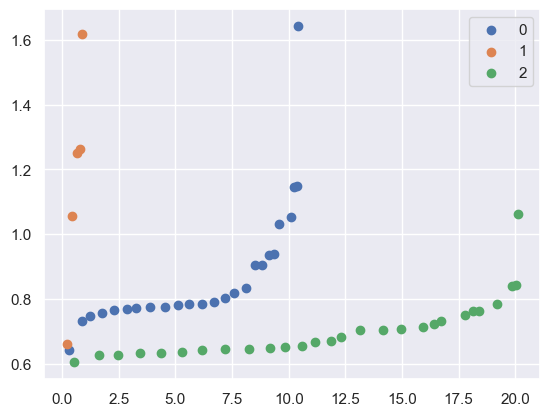

In [31]:
fig, ax = plt.subplots()

state_cluster_lcow = bw_cluster_lcow_sorted[bw_cluster_lcow_sorted['state_alpha']=='WI']

for cluster in state_cluster_lcow['cluster_id'].unique():
    temp = state_cluster_lcow[state_cluster_lcow['cluster_id']==cluster]
    ax.scatter(temp['avg_well_yield_m3/s'].cumsum(),temp['cluster_lcow'],label = cluster)

ax.legend()

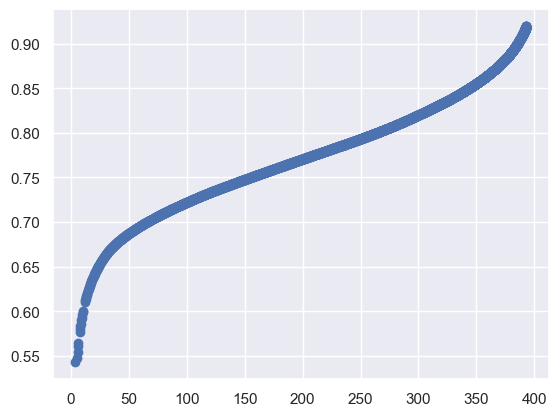

In [15]:
bw_df_temp_sorted_1 = bw_df.sort_values('lcow')

lcow = 0
total_water = 0

fig, ax = plt.subplots()

# Calculating LCOW as a function of well yield without clustering
flow = bw_df_temp_sorted_1['well_yield']*bw_df_temp_sorted_1['recovery']/100
cum_flow = flow.cumsum()

lcow_t = bw_df_temp_sorted_1['lcow'] + bw_df_temp_sorted_1['pipe_lcow']
cost = lcow_t*flow
cum_cost = cost.cumsum()

avg_lcow = np.divide(cum_cost, cum_flow, out=np.zeros_like(cum_cost), where=cum_flow!=0) 

ax.scatter(cum_flow,avg_lcow)

In [19]:
wacc = 0.05
plant_lifetime_yrs =30
capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
capital_recovery_factor

0.06505143508027657